# Results

In [1]:
import json
import math
import re
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
from colors import *
from metrics import score, recall, ndcg, mrr

In [2]:
def clean_string(string):
    if not string:
        return ""
    return re.sub(r'\W+','', string).lower() 

def load_preds(path):
    preds = defaultdict(lambda: defaultdict(dict))
    for key_type in ["title", "id"]:
        for method in ["semantic_scholar", "google_scholar", "gpt-4o"]:
            if method == "gpt-4o":
                file_paths = [(Path(f'{path}/{method}/run{run_i}/preds_annot{annotator_i}.json'), f"annotator{annotator_i}_run{run_i}") for annotator_i in [1,2,3] for run_i in [1,2,3]]
            else:
                file_paths = [(Path(f'{path}/{method}/preds_annot{annotator_i}.json'),f"annotator{annotator_i}")  for annotator_i in [1,2,3]]
            for file_path in file_paths:
                preds[key_type][method][file_path[1]] = { id_:[clean_string(ref[key_type]) for ref in references] for id_, references in json.loads(file_path[0].read_text()).items()}
    return json.loads(json.dumps(preds))

# Amount of undetermined ids per year

In [3]:
def mean_year(preds, year):    
    return np.mean([(len([v for v in vs if v])/len(vs) if len(vs) else 1) for k, vs in preds.items() if str(year) in k])

def mean_match_ids(preds):
    scores = defaultdict(lambda: defaultdict(dict))
    for year in [2020, 2021, 2022, 2023, 2024]:
        for key_type in ["id"]:
            for method in ["semantic_scholar", "google_scholar", "gpt-4o"]:
                if method == "gpt-4o":
                    scores[year][method] = np.mean([mean_year(preds[key_type][method][f"annotator{annotator_i}_run{run_i}"], year) for annotator_i in [1,2,3]for annotator_i in [1,2,3] for run_i in [1,2,3]])
                else:
                    scores[year][method] = np.mean([mean_year(preds[key_type][method][f"annotator{annotator_i}"], year) for annotator_i in [1,2,3]])
    return json.loads(json.dumps(scores))

In [4]:
preds = load_preds("preds_search_engines/preds")
mean_match_ids(preds)

{'2020': {'semantic_scholar': 1.0,
  'google_scholar': 0.9340958605664489,
  'gpt-4o': 0.7060173657657528},
 '2021': {'semantic_scholar': 1.0,
  'google_scholar': 0.9745614035087719,
  'gpt-4o': 0.6881336893150483},
 '2022': {'semantic_scholar': 1.0,
  'google_scholar': 0.9543859649122807,
  'gpt-4o': 0.6580686924557064},
 '2023': {'semantic_scholar': 1.0,
  'google_scholar': 0.9307692307692307,
  'gpt-4o': 0.5487350423634857},
 '2024': {'semantic_scholar': 1.0,
  'google_scholar': 0.9033333333333333,
  'gpt-4o': 0.363926228061075}}

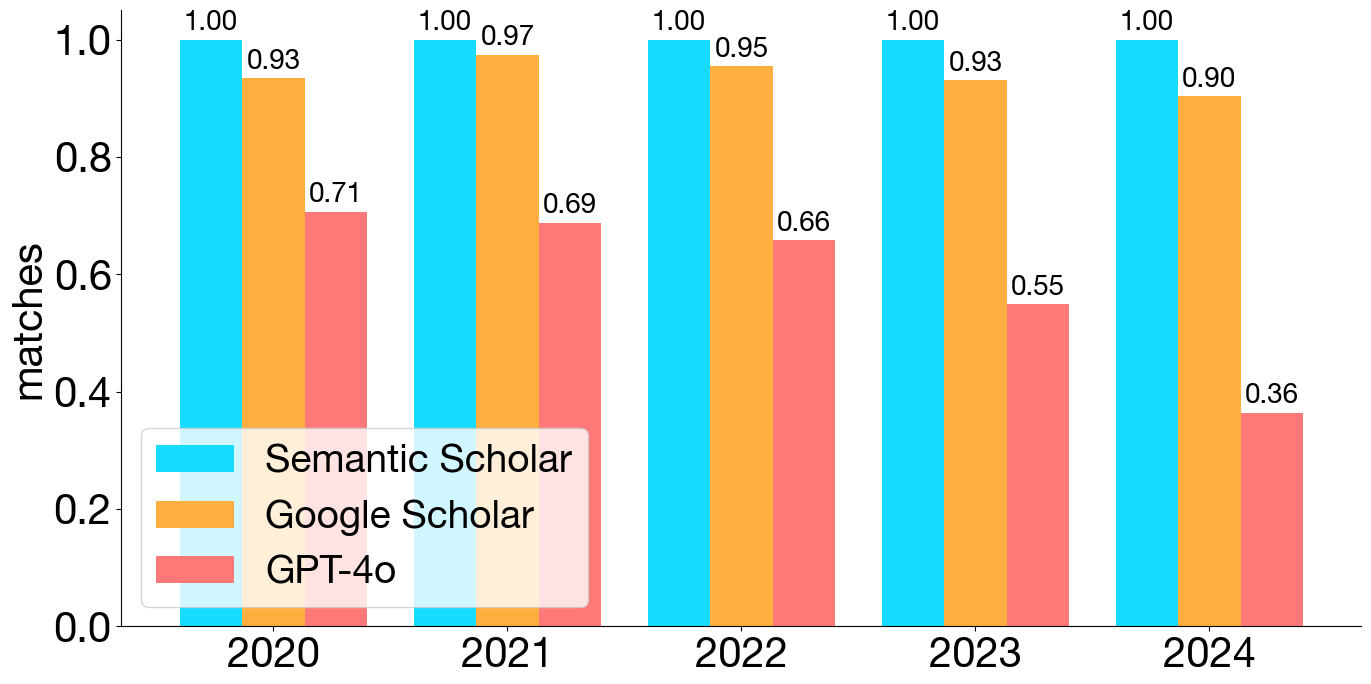

In [5]:
import matplotlib.pyplot as plt

# Set global font family and other font properties
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica Neue'],
    'font.size': 20,
    'axes.titlesize': 30,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'legend.fontsize': 28
})

years = [2020, 2021, 2022, 2023, 2024]
data = defaultdict(list)
for i, method in enumerate(["semantic_scholar", "google_scholar", "gpt-4o"]):
    data["year"] = years
    for year in years:
        data[method].append(mean_match_ids(preds)[str(year)][method])

df = pd.DataFrame(data)
ax = df.plot.bar(x="year", y=["semantic_scholar", "google_scholar", "gpt-4o"], ylabel="matches", color=colormap, figsize=(16,8), width=0.8)

for i, container in enumerate(ax.containers):
    ax.bar_label(container, fmt="{:0.2f}", padding=3)

ax.tick_params(axis='x', labelrotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("", fontsize=0)
ax.set_ylabel("matches", fontsize=30)
ax.legend(labels=["Semantic Scholar", "Google Scholar", "GPT-4o"])